Step 1: Reload the file (to get raw data)

 STEP 1: Reload cleanly with all columns as strings

In [0]:
file_path = "/FileStore/tables/TATAMOTORS-3.csv"

df_raw = spark.read.option("header", True).option("inferSchema", False).csv(file_path)


 STEP 2: Remove the invalid row (second header row)

In [0]:
df_cleaned = df_raw.filter(~df_raw["Close"].contains("TATAMOTORS.NS"))


STEP 3: Rename Price to DateString

In [0]:
df_cleaned = df_cleaned.withColumnRenamed("Price", "DateString")


STEP 4: Extract date using substring

In [0]:
from pyspark.sql.functions import substring, col

df_cleaned = df_cleaned.withColumn("Date", substring("DateString", 1, 10))


 STEP 5: Convert string to proper date format

In [0]:
from pyspark.sql.functions import to_date

df_cleaned = df_cleaned.withColumn("Date", to_date("Date", "yyyy-MM-dd"))


STEP 6: Cast numeric columns

In [0]:
numeric_columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
for c in numeric_columns:
    df_cleaned = df_cleaned.withColumn(c, col(c).cast("double"))


In [0]:
df_cleaned.select("Date", "Close").show(5)
df_cleaned.printSchema()


+----------+------------------+
|      Date|             Close|
+----------+------------------+
|1991-01-02|21.857864379882812|
|1991-01-03|21.857864379882812|
|1991-01-04|21.857864379882812|
|1991-01-07| 21.10930824279785|
|1991-01-08| 21.10930824279785|
+----------+------------------+
only showing top 5 rows

root
 |-- DateString: string (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Date: date (nullable = true)



Step 1: Analyze Daily Returns


In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, round

# Define a window specification ordered by Date
window_spec = Window.orderBy("Date")

# Use lag to get the previous day's Close price
df_with_prev = df_cleaned.withColumn("Prev_Close", lag("Close").over(window_spec))

# Calculate Daily_Return as percentage change
df_with_return = df_with_prev.withColumn(
    "Daily_Return",
    round(((col("Close") - col("Prev_Close")) / col("Prev_Close")) * 100, 4)  # rounded to 4 decimals
)

# Show the result
df_with_return.select("Date", "Close", "Prev_Close", "Daily_Return").show(10)


+----------+------------------+------------------+------------+
|      Date|             Close|        Prev_Close|Daily_Return|
+----------+------------------+------------------+------------+
|1991-01-02|21.857864379882812|              null|        null|
|1991-01-03|21.857864379882812|21.857864379882812|         0.0|
|1991-01-04|21.857864379882812|21.857864379882812|         0.0|
|1991-01-07| 21.10930824279785|21.857864379882812|     -3.4247|
|1991-01-08| 21.10930824279785| 21.10930824279785|         0.0|
|1991-01-09|20.510461807250977| 21.10930824279785|     -2.8369|
|1991-01-10|20.510461807250977|20.510461807250977|         0.0|
|1991-01-11|20.959596633911133|20.510461807250977|      2.1898|
|1991-01-14|20.360750198364258|20.959596633911133|     -2.8571|
|1991-01-15|20.360750198364258|20.360750198364258|         0.0|
+----------+------------------+------------------+------------+
only showing top 10 rows



 Step 2: Compute 50-day and 200-day Moving Averages

In [0]:
from pyspark.sql.functions import avg

# Define moving average windows ordered by Date
window_50 = Window.orderBy("Date").rowsBetween(-49, 0)    # 50-day window
window_200 = Window.orderBy("Date").rowsBetween(-199, 0)  # 200-day window

# Compute SMAs
df_with_sma = df_with_return \
    .withColumn("SMA_50", avg("Close").over(window_50)) \
    .withColumn("SMA_200", avg("Close").over(window_200))

# Show sample output
df_with_sma.select("Date", "Close", "SMA_50", "SMA_200").show(10)


+----------+------------------+------------------+------------------+
|      Date|             Close|            SMA_50|           SMA_200|
+----------+------------------+------------------+------------------+
|1991-01-02|21.857864379882812|21.857864379882812|21.857864379882812|
|1991-01-03|21.857864379882812|21.857864379882812|21.857864379882812|
|1991-01-04|21.857864379882812|21.857864379882812|21.857864379882812|
|1991-01-07| 21.10930824279785|21.670725345611572|21.670725345611572|
|1991-01-08| 21.10930824279785| 21.55844192504883| 21.55844192504883|
|1991-01-09|20.510461807250977| 21.38377857208252| 21.38377857208252|
|1991-01-10|20.510461807250977| 21.25901903424944| 21.25901903424944|
|1991-01-11|20.959596633911133|21.221591234207153|21.221591234207153|
|1991-01-14|20.360750198364258| 21.12594223022461| 21.12594223022461|
|1991-01-15|20.360750198364258|21.049423027038575|21.049423027038575|
+----------+------------------+------------------+------------------+
only showing top 10 

In [0]:
df_with_sma.display()

DateString Adj Close Close High Low Open Volume Date Prev_Close Daily_Return SMA_50 SMA_200 1991-01-02 00:00:00+00:00 15.690223693847656 21.857864379882812 21.857864379882812 20.959596633911133 20.959596633911133 0.0 1991-01-02 null null 21.857864379882812 21.857864379882812 1991-01-03 00:00:00+00:00 15.690223693847656 21.857864379882812 21.857864379882812 20.959596633911133 20.959596633911133 0.0 1991-01-03 21.857864379882812 0.0 21.857864379882812 21.857864379882812 1991-01-04 00:00:00+00:00 15.690223693847656 21.857864379882812 21.857864379882812 21.857864379882812 21.857864379882812 0.0 1991-01-04 21.857864379882812 0.0 21.857864379882812 21.857864379882812 1991-01-07 00:00:00+00:00 15.152884483337402 21.10930824279785 21.25901985168457 20.061328887939453 20.360750198364258 0.0 1991-01-07 21.857864379882812 -3.4247 21.670725345611572 21.670725345611572 1991-01-08 00:00:00+00:00 15.152884483337402 21.10930824279785 21.10930824279785 21.10930824279785 21.10930824279785 0.0 1991-01-08 21.10930824279785 0.0 21.55844192504883 21.55844192504883 1991-01-09 00:00:00+00:00 14.723020553588867 20.510461807250977 21.25901985168457 20.061328887939453 21.25901985168457 0.0 1991-01-09 21.10930824279785 -2.8369 21.38377857208252 21.38377857208252 1991-01-10 00:00:00+00:00 14.723020553588867 20.510461807250977 20.510461807250977 20.510461807250977 20.510461807250977 0.0 1991-01-10 20.510461807250977 0.0 21.25901903424944 21.25901903424944 1991-01-11 00:00:00+00:00 15.045415878295898 20.959596633911133 20.959596633911133 20.061328887939453 20.360750198364258 0.0 1991-01-11 20.510461807250977 2.1898 21.221591234207153 21.221591234207153 1991-01-14 00:00:00+00:00 14.615549087524414 20.360750198364258 20.660173416137695 20.061328887939453 20.660173416137695 0.0 1991-01-14 20.959596633911133 -2.8571 21.12594223022461 21.12594223022461 1991-01-15 00:00:00+00:00 14.615549087524414 20.360750198364258 20.360750198364258 20.360750198364258 20.360750198364258 0.0 1991-01-15 20.360750198364258 0.0 21.049423027038575 21.049423027038575 1991-01-16 00:00:00+00:00 14.615549087524414 20.360750198364258 20.360750198364258 20.360750198364258 20.360750198364258 0.0 1991-01-16 20.360750198364258 0.0 20.98681640625 20.98681640625 1991-01-17 00:00:00+00:00 14.615549087524414 20.360750198364258 20.360750198364258 20.360750198364258 20.360750198364258 0.0 1991-01-17 20.360750198364258 0.0 20.93464422225952 20.93464422225952 1991-01-18 00:00:00+00:00 14.615549087524414 20.360750198364258 20.360750198364258 20.360750198364258 20.360750198364258 0.0 1991-01-18 20.360750198364258 0.0 20.89049852811373 20.89049852811373 1991-01-21 00:00:00+00:00 14.615549087524414 20.360750198364258 20.360750198364258 20.360750198364258 20.360750198364258 0.0 1991-01-21 20.360750198364258 0.0 20.852659361703054 20.852659361703054 1991-01-22 00:00:00+00:00 14.615549087524414 20.360750198364258 20.360750198364258 20.360750198364258 20.360750198364258 0.0 1991-01-22 20.360750198364258 0.0 20.819865417480468 20.819865417480468 1991-01-23 00:00:00+00:00 14.400615692138672 20.061328887939453 20.660173416137695 19.761905670166016 20.660173416137695 0.0 1991-01-23 20.360750198364258 -1.4706 20.772456884384155 20.772456884384155 1991-01-24 00:00:00+00:00 14.185678482055664 19.761905670166016 19.761905670166016 19.462482452392578 19.761905670166016 0.0 1991-01-24 20.061328887939453 -1.4925 20.7130126953125 20.7130126953125 1991-01-25 00:00:00+00:00 13.75581169128418 19.16305923461914 19.761905670166016 18.863637924194336 19.761905670166016 0.0 1991-01-25 19.761905670166016 -3.0303 20.626904169718426 20.626904169718426 1991-01-28 00:00:00+00:00 13.75581169128418 19.16305923461914 19.16305923461914 19.16305923461914 19.16305923461914 0.0 1991-01-28 19.16305923461914 0.0 20.549859699450042 20.549859699450042 1991-01-29 00:00:00+00:00 13.75581169128418 19.16305923461914 19.16305923461914 19.16305923461914 19.16305923461914 0.0 1991-01-29 19.16305923461914 0.0 20.480519676208495 20.480519676208495 19

Step 3: Exploratory Data Analysis (EDA)

3.1 Show summary stats for key columns

In [0]:
# Describe basic stats
df_with_sma.select("Open", "Close", "Volume", "Daily_Return").describe().show()


+-------+------------------+------------------+--------------------+-------------------+
|summary|              Open|             Close|              Volume|       Daily_Return|
+-------+------------------+------------------+--------------------+-------------------+
|  count|              8556|              8556|                8556|               8555|
|   mean|195.14354385310884|194.82805112100417|1.2832852413510986E7|0.08285424897720642|
| stddev| 203.9594345770023|203.50642757932866| 1.933393274694915E7|  2.880798640682674|
|    min|11.114574432373047|11.267878532409668|                 0.0|           -40.5128|
|    max|            1167.0|1161.8499755859375|        3.90577839E8|            67.2414|
+-------+------------------+------------------+--------------------+-------------------+



 3.2 Find high-volume days and analyze price movement
 

In [0]:
# Top 10 highest volume days
df_with_sma.orderBy(col("Volume").desc()).select("Date", "Volume", "Close").show(10)


+----------+------------+------------------+
|      Date|      Volume|             Close|
+----------+------------+------------------+
|2021-01-12|3.90577839E8| 237.8000030517578|
|2021-01-22|3.16008609E8| 289.3500061035156|
|2021-01-21|2.83614463E8| 290.6000061035156|
|2021-02-02|2.51965965E8|             322.0|
|2021-01-15|2.50038029E8|260.29998779296875|
|2021-02-03|2.24190114E8|             331.0|
|2020-06-16|2.15476711E8|             94.75|
|2021-01-20|2.05145151E8| 274.8999938964844|
|2021-10-13|1.97949387E8| 506.8999938964844|
|2020-08-26|1.97510376E8|137.89999389648438|
+----------+------------+------------------+
only showing top 10 rows



 3.3 Identify volatility using 30-day rolling standard deviation

In [0]:
from pyspark.sql.functions import stddev

# 30-day rolling window for standard deviation of Daily_Return
window_30 = Window.orderBy("Date").rowsBetween(-29, 0)

df_volatility = df_with_sma.withColumn("Volatility_30", stddev("Daily_Return").over(window_30))

# View volatility
df_volatility.select("Date", "Daily_Return", "Volatility_30").show(10)


+----------+------------+------------------+
|      Date|Daily_Return|     Volatility_30|
+----------+------------+------------------+
|1991-01-02|        null|              null|
|1991-01-03|         0.0|              null|
|1991-01-04|         0.0|               0.0|
|1991-01-07|     -3.4247|1.9772514668937116|
|1991-01-08|         0.0|1.7123500000000003|
|1991-01-09|     -2.8369|  1.72735670809477|
|1991-01-10|         0.0|1.6273884563926342|
|1991-01-11|      2.1898|1.9236808401504406|
|1991-01-14|     -2.8571|1.9542484579847348|
|1991-01-15|         0.0|1.8506893991008984|
+----------+------------+------------------+
only showing top 10 rows



 3.4 Perform trend analysis using SMA crossovers (Golden/Death Cross)

In [0]:
from pyspark.sql.functions import lag, when

# Detect crossover events
df_trend = df_volatility.withColumn("Prev_SMA_50", lag("SMA_50").over(window_spec)) \
    .withColumn("Prev_SMA_200", lag("SMA_200").over(window_spec)) \
    .withColumn("Trend_Signal", when(
        (col("Prev_SMA_50") < col("Prev_SMA_200")) & (col("SMA_50") >= col("SMA_200")), "Golden Cross"
    ).when(
        (col("Prev_SMA_50") > col("Prev_SMA_200")) & (col("SMA_50") <= col("SMA_200")), "Death Cross"
    ).otherwise(None))

# Show crossover signals
df_trend.filter(col("Trend_Signal").isNotNull()).select("Date", "SMA_50", "SMA_200", "Trend_Signal").show(10)


+----------+-----------------+------------------+------------+
|      Date|           SMA_50|           SMA_200|Trend_Signal|
+----------+-----------------+------------------+------------+
|1991-04-05|20.73203498840332|20.704206242280847|Golden Cross|
|1992-08-17|45.79671905517578|45.968138217926025| Death Cross|
|1993-09-06|27.05584457397461| 26.88592227935791|Golden Cross|
|1995-01-12|61.61223190307617| 61.67481088638306| Death Cross|
|1995-06-19|61.32837882995605| 61.11309373855591|Golden Cross|
|1996-10-17|88.81541641235351|  88.8594913482666| Death Cross|
|1997-06-03|73.71281768798828|  73.6391354560852|Golden Cross|
|1997-09-17|72.06920158386231| 72.14365041732788| Death Cross|
|1999-01-29|32.24989627838135| 32.07862654685974|Golden Cross|
|1999-12-31|43.36427993774414| 43.49736710548401| Death Cross|
+----------+-----------------+------------------+------------+
only showing top 10 rows



 Step 4: Correlation and Seasonal Analysis

 4.1 Calculate correlation between Close and Volume

In [0]:
# Correlation between Close and Volume
correlation = df_trend.stat.corr("Close", "Volume")
print(f"Correlation between Close and Volume: {correlation}")


Correlation between Close and Volume: 0.06883224303321438


4.2 Analyze monthly average prices and volume (seasonality)


In [0]:
from pyspark.sql.functions import year, month

# Add Year and Month columns
df_seasonal = df_trend.withColumn("Year", year("Date")).withColumn("Month", month("Date"))

# Group by Year and Month and get average Close and Volume
monthly_stats = df_seasonal.groupBy("Year", "Month") \
    .agg(
        avg("Close").alias("Avg_Close"),
        avg("Volume").alias("Avg_Volume")
    ) \
    .orderBy("Year", "Month")

# Show monthly trends
monthly_stats.show(12)


+----+-----+------------------+----------+
|Year|Month|         Avg_Close|Avg_Volume|
+----+-----+------------------+----------+
|1991|    1|20.374360691417348|       0.0|
|1991|    2|  19.7020206451416|       0.0|
|1991|    3|21.515667143322172|       0.0|
|1991|    4| 25.72314115004106|       0.0|
|1991|    5|27.162855562956437|       0.0|
|1991|    6|27.419643783569335|       0.0|
|1991|    7| 29.23277879797894|       0.0|
|1991|    8| 35.97837257385254|       0.0|
|1991|    9|39.224388122558594|       0.0|
|1991|   10| 38.34043934034265|       0.0|
|1991|   11| 37.32091467721121|       0.0|
|1991|   12|  33.0930250341242|       0.0|
+----+-----+------------------+----------+
only showing top 12 rows



4.3 Detect anomalous Daily_Returns using mean ± 3 * stddev


In [0]:
from pyspark.sql.functions import mean, stddev

# Compute mean and stddev of Daily_Return
stats = df_seasonal.select(mean("Daily_Return").alias("mean_return"),
                           stddev("Daily_Return").alias("stddev_return")).collect()[0]

mean_val = stats["mean_return"]
stddev_val = stats["stddev_return"]

# Filter for anomalies (returns outside mean ± 3 * stddev)
anomalies = df_seasonal.filter(
    (col("Daily_Return") > mean_val + 3 * stddev_val) |
    (col("Daily_Return") < mean_val - 3 * stddev_val)
)

# Show anomalous return days
anomalies.select("Date", "Daily_Return", "Close", "Volume").orderBy("Date").show(10)


+----------+------------+------------------+------+
|      Date|Daily_Return|             Close|Volume|
+----------+------------+------------------+------+
|1991-02-19|     15.2542|20.360750198364258|   0.0|
|1992-03-24|     10.8434| 55.09379577636719|   0.0|
|1992-04-08|     14.7059| 70.06493377685547|   0.0|
|1992-04-22|     12.2641| 71.26262664794922|   0.0|
|1992-04-28|    -15.1261| 60.48340606689453|   0.0|
|1992-07-15|    -10.4651| 46.11111068725586|   0.0|
|1992-07-23|    -10.1449|  37.1284294128418|   0.0|
|1992-11-06|    -13.7097|32.038238525390625|   0.0|
|1993-02-03|    -40.5128| 17.36652374267578|   0.0|
|1993-02-04|     67.2414| 29.04401206970215|   0.0|
+----------+------------+------------------+------+
only showing top 10 rows



5.1 Export data to Pandas for forecasting

In [0]:
# Convert to Pandas DataFrame for modeling (if using smaller sample)
df_pandas = df_seasonal.select("Date", "Close").orderBy("Date").toPandas()
df_pandas.set_index("Date", inplace=True)


 ARIMA Model using statsmodels

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic

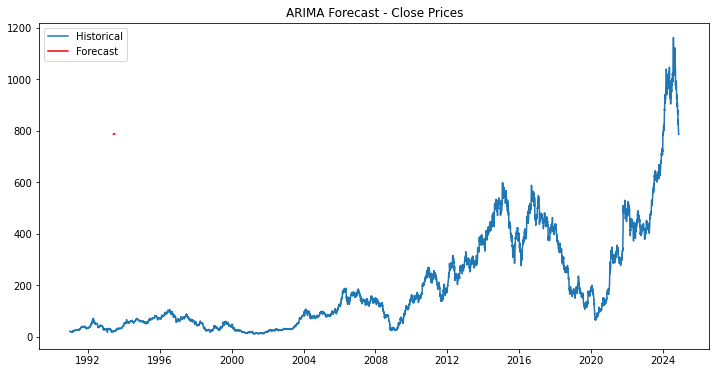

In [0]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model
model = ARIMA(df_pandas["Close"], order=(5,1,0))  # (p,d,q) can be tuned
model_fit = model.fit()

# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_pandas["Close"], label="Historical")
plt.plot(forecast.index, forecast, label="Forecast", color='red')
plt.legend()
plt.title("ARIMA Forecast - Close Prices")
plt.show()


Step 6: Strategic Insights and Visualization

6.1 Identify Price Trends: Uptrend, Downtrend, Sideways


In [0]:
from pyspark.sql.functions import when

df_insights = df_trend.withColumn("Market_Trend", when(
    (col("Close") > col("SMA_50")) & (col("SMA_50") > col("SMA_200")), "Uptrend"
).when(
    (col("Close") < col("SMA_50")) & (col("SMA_50") < col("SMA_200")), "Downtrend"
).otherwise("Sideways"))

# Show sample trend classification
df_insights.select("Date", "Close", "SMA_50", "SMA_200", "Market_Trend").orderBy("Date").show(10)


+----------+------------------+------------------+------------------+------------+
|      Date|             Close|            SMA_50|           SMA_200|Market_Trend|
+----------+------------------+------------------+------------------+------------+
|1991-01-02|21.857864379882812|21.857864379882812|21.857864379882812|    Sideways|
|1991-01-03|21.857864379882812|21.857864379882812|21.857864379882812|    Sideways|
|1991-01-04|21.857864379882812|21.857864379882812|21.857864379882812|    Sideways|
|1991-01-07| 21.10930824279785|21.670725345611572|21.670725345611572|    Sideways|
|1991-01-08| 21.10930824279785| 21.55844192504883| 21.55844192504883|    Sideways|
|1991-01-09|20.510461807250977| 21.38377857208252| 21.38377857208252|    Sideways|
|1991-01-10|20.510461807250977| 21.25901903424944| 21.25901903424944|    Sideways|
|1991-01-11|20.959596633911133|21.221591234207153|21.221591234207153|    Sideways|
|1991-01-14|20.360750198364258| 21.12594223022461| 21.12594223022461|    Sideways|
|199

6.2 High Volatility Detection


In [0]:
df_insights = df_insights.withColumn("High_Volatility_Flag", when(col("Volatility_30") > 5.0, "Yes").otherwise("No"))

# Show where high volatility occurs
df_insights.select("Date", "Volatility_30", "High_Volatility_Flag").filter(col("High_Volatility_Flag") == "Yes").show(10)


+----------+------------------+--------------------+
|      Date|     Volatility_30|High_Volatility_Flag|
+----------+------------------+--------------------+
|1992-04-28| 5.384998511108771|                 Yes|
|1992-04-29| 5.363007225540107|                 Yes|
|1992-04-30|5.4433464242411445|                 Yes|
|1992-05-01| 5.446218245749368|                 Yes|
|1992-05-04| 5.446218245749368|                 Yes|
|1992-05-05|5.1176691675345065|                 Yes|
|1992-05-06| 5.230455869463224|                 Yes|
|1992-05-07| 5.232143401120142|                 Yes|
|1992-05-08| 5.213646377747095|                 Yes|
|1992-05-11| 5.172578459176172|                 Yes|
+----------+------------------+--------------------+
only showing top 10 rows



6.3 Visualizations (if using Databricks)

In [0]:
# Create a temporary table
df_insights.createOrReplaceTempView("stock_insights")




Volume vs Close

In [0]:
%sql
-- Run this SQL:
SELECT Date, Close, Volume FROM stock_insights ORDER BY Date
-- Then visualize as Line or Area Chart


Date Close Volume 1991-01-02 21.857864379882812 0.0 1991-01-03 21.857864379882812 0.0 1991-01-04 21.857864379882812 0.0 1991-01-07 21.10930824279785 0.0 1991-01-08 21.10930824279785 0.0 1991-01-09 20.510461807250977 0.0 1991-01-10 20.510461807250977 0.0 1991-01-11 20.959596633911133 0.0 1991-01-14 20.360750198364258 0.0 1991-01-15 20.360750198364258 0.0 1991-01-16 20.360750198364258 0.0 1991-01-17 20.360750198364258 0.0 1991-01-18 20.360750198364258 0.0 1991-01-21 20.360750198364258 0.0 1991-01-22 20.360750198364258 0.0 1991-01-23 20.061328887939453 0.0 1991-01-24 19.761905670166016 0.0 1991-01-25 19.16305923461914 0.0 1991-01-28 19.16305923461914 0.0 1991-01-29 19.16305923461914 0.0 1991-01-30 19.16305923461914 0.0 1991-01-31 19.462482452392578 0.0 1991-02-01 19.761905670166016 0.0 1991-02-04 20.061328887939453 0.0 1991-02-05 20.061328887939453 0.0 1991-02-06 20.061328887939453 0.0 1991-02-07 19.462482452392578 0.0 1991-02-08 18.863637924194336 0.0 1991-02-11 18.26479148864746 0.0 1991-02-12 18.26479148864746 0.0 1991-02-13 17.21681022644043 0.0 1991-02-14 17.516233444213867 0.0 1991-02-15 17.665945053100586 0.0 1991-02-18 17.665945053100586 0.0 1991-02-19 20.360750198364258 0.0 1991-02-20 19.9116153717041 0.0 1991-02-21 19.761905670166016 0.0 1991-02-22 20.660173416137695 0.0 1991-02-25 20.660173416137695 0.0 1991-02-26 22.30699920654297 0.0 1991-02-27 23.05555534362793 0.0 1991-02-28 22.456710815429688 0.0 1991-03-01 22.456710815429688 0.0 1991-03-04 22.456710815429688 0.0 1991-03-05 22.756132125854492 0.0 1991-03-06 22.756132125854492 0.0 1991-03-07 21.857864379882812 0.0 1991-03-08 22.15728759765625 0.0 1991-03-11 21.708152770996094 0.0 1991-03-12 21.708152770996094 0.0 1991-03-13 21.708152770996094 0.0 1991-03-14 21.708152770996094 0.0 1991-03-15 21.708152770996094 0.0 1991-03-18 21.25901985168457 0.0 1991-03-19 21.25901985168457 0.0 1991-03-20 20.959596633911133 0.0 1991-03-21 20.959596633911133 0.0 1991-03-22 20.660173416137695 0.0 1991-03-25 20.959596633911133 0.0 1991-03-26 20.809885025024414 0.0 1991-03-27 20.660173416137695 0.0 1991-03-28 20.660173416137695 0.0 1991-03-29 20.660173416137695 0.0 1991-04-01 21.558441162109375 0.0 1991-04-02 22.456710815429688 0.0 1991-04-03 22.756132125854492 0.0 1991-04-04 22.905845642089844 0.0 1991-04-05 24.10353660583496 0.0 1991-04-08 25.450937271118164 0.0 1991-04-09 25.450937271118164 0.0 1991-04-10 25.450937271118164 0.0 1991-04-11 25.90007209777832 0.0 1991-04-12 26.798341751098633 0.0 1991-04-15 27.247474670410156 0.0 1991-04-16 26.798341751098633 0.0 1991-04-17 26.798341751098633 0.0 1991-04-18 26.648630142211914 0.0 1991-04-19 26.94805335998535 0.0 1991-04-22 27.247474670410156 0.0 1991-04-23 26.94805335998535 0.0 1991-04-24 26.94805335998535 0.0 1991-04-25 26.94805335998535 0.0 1991-04-26 26.94805335998535 0.0 1991-04-29 26.94805335998535 0.0 1991-04-30 26.648630142211914 0.0 1991-05-01 26.648630142211914 0.0 1991-05-02 26.648630142211914 0.0 1991-05-03 27.84632110595703 0.0 1991-05-06 27.097763061523438 0.0 1991-05-07 27.097763061523438 0.0 1991-05-08 27.247474670410156 0.0 1991-05-09 27.097763061523438 0.0 1991-05-10 27.546897888183594 0.0 1991-05-13 27.247474670410156 0.0 1991-05-14 27.397186279296875 0.0 1991-05-15 27.397186279296875 0.0 1991-05-16 27.097763061523438 0.0 1991-05-17 27.097763061523438 0.0 1991-05-20 27.097763061523438 0.0 1991-05-21 27.546897888183594 0.0 1991-05-22 27.546897888183594 0.0 1991-05-23 27.097763061523438 0.0 1991-05-24 27.097763061523438 0.0 1991-05-27 26.94805335998535 0.0 1991-05-28 26.94805335998535 0.0 1991-05-29 26.94805335998535 0.0 1991-05-30 26.798341751098633 0.0 1991-05-31 27.247474670410156 0.0 1991-06-03 26.94805335998535 0.0 1991-06-04 26.94805335998535 0.0 1991-06-05 26.798341751098633 0.0 1991-06-06 26.648630142211914 0.0 1991-06-07 26.648630142211914 0.0 1991-06-10 26.648630142211914 0.0 1991-06-11 26.94805335998535 0.0 1991-06-12 27.397186279296875 0.0 1991-06-13 26.94805335998535 0.0 1991-06-14 26.94805335998535 0.0 199

Daily Returns Distribution

In [0]:
# Display Daily_Return as histogram (Databricks built-in display)
display(df_insights.select("Daily_Return"))


Daily_Return null 0.0 0.0 -3.4247 0.0 -2.8369 0.0 2.1898 -2.8571 0.0 0.0 0.0 0.0 0.0 0.0 -1.4706 -1.4925 -3.0303 0.0 0.0 0.0 1.5625 1.5385 1.5152 0.0 0.0 -2.9851 -3.0769 -3.1746 0.0 -5.7377 1.7391 0.8547 0.0 15.2542 -2.2059 -0.7519 4.5455 0.0 7.971 3.3557 -2.5974 0.0 0.0 1.3333 0.0 -3.9474 1.3699 -2.027 0.0 0.0 0.0 0.0 -2.069 0.0 -1.4085 0.0 -1.4286 1.4493 -0.7143 -0.7194 0.0 0.0 4.3478 4.1667 1.3333 0.6579 5.2288 5.5901 0.0 0.0 1.7647 3.4682 1.676 -1.6483 0.0 -0.5587 1.1236 1.1111 -1.0989 0.0 0.0 0.0 0.0 -1.1111 0.0 0.0 4.4944 -2.6882 0.0 0.5525 -0.5495 1.6575 -1.087 0.5495 0.0 -1.0929 0.0 0.0 1.6575 0.0 -1.6304 0.0 -0.5525 0.0 0.0 -0.5556 1.676 -1.0989 0.0 -0.5556 -0.5587 0.0 0.0 1.1236 1.6667 -1.6393 0.0 1.6667 3.2787 0.0 2.6455 0.0 -5.1546 1.6304 -4.8128 5.618 -3.7234 0.0 3.8674 -1.0638 -2.1505 2.1978 0.0 1.6129 2.6455 3.0928 0.0 -3.0 1.5464 -0.5076 0.0 0.0 -2.0408 0.0 0.5208 4.6632 3.4653 1.9139 -0.939 -1.4218 1.9231 0.0 1.8868 0.0 2.3148 0.0 1.81 2.6667 3.8961 1.6667 0.0 0.8197 0.0 -2.0325 0.8299 2.8807 2.0 4.3137 -0.7519 0.7576 0.0 -1.5038 0.0 -1.145 -0.3861 2.7132 0.3774 0.0 -1.1278 0.0 0.0 2.2814 1.8587 -2.5547 -0.7491 0.0 -1.8868 0.0 -1.5385 -0.3906 -3.5294 6.0976 -0.7663 -0.7722 0.0 -2.7237 -3.2 2.4793 0.0 -0.8065 2.8455 0.0 -1.1858 0.4 1.992 0.0 0.0 -0.3906 0.0 1.6471 1.0803 0.0 0.0 4.5801 -2.9197 2.2556 1.1029 0.0 -2.9091 0.0 0.0 -0.3745 -0.3759 -1.1321 -0.7634 -0.7692 -2.3256 -3.5714 2.8807 -5.2 0.0 -3.3755 0.0 -3.9301 1.8182 0.0 1.7857 -0.8772 -1.7699 -2.2523 -1.3825 2.8037 -2.7273 0.4673 0.0 -0.9302 0.0 4.2254 -1.8018 0.4587 1.8265 0.4484 0.8929 0.4425 0.0 0.0 0.0 0.0 0.0 0.8811 0.0 2.1834 -0.8547 -0.8621 0.4348 -0.8658 0.0 4.8035 0.8333 0.8264 -2.459 0.0 -0.8403 3.3898 0.4098 1.6327 -1.2048 -0.813 0.0 1.6393 3.2258 -0.3906 -4.3137 2.459 0.8 0.7936 -2.3622 0.8065 0.0 1.6 2.3622 0.0 6.1538 -2.1739 -1.4815 1.1278 0.7435 0.369 0.0 5.8824 6.9444 5.1948 4.9383 0.5882 0.0 0.0 0.0 0.0 -5.2632 -3.7037 3.8462 2.4691 1.2048 0.0 -2.3809 0.0 1.2195 0.0 10.8434 4.3478 0.0 -2.0833 6.383 2.0 0.0 0.9804 0.0 -1.9418 0.9901 14.7059 0.0 -1.7094 -7.8261 0.0 0.0 0.0 0.0 0.0 0.0 12.2641 0.0 0.0 0.0 -15.1261 -0.9901 6.0 0.0 0.0 0.0 -6.6038 1.0101 0.0 -5.0 -6.3158 4.4944 -2.1505 0.0 -1.0989 3.3333 -1.0753 0.0 -2.1739 -1.6667 -3.9548 -2.3529 -1.2048 -0.6098 1.227 6.0606 -2.8571 0.0 0.5882 -0.5848 2.9412 0.5714 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -2.2727 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -10.4651 -6.4935 -2.7778 0.0 2.8571 -4.1667 -10.1449 0.0 4.8387 1.5385 -4.5455 0.0 1.5873 -0.7813 -0.7874 0.0 -5.5556 5.042 -0.8 0.4032 -0.4016 0.0 3.2258 2.3438 2.2901 1.4925 -0.7353 0.0 0.7407 -4.0441 -0.7663 -0.3861 6.2015 0.0 1.4599 -2.8777 0.7407 2.2059 2.1583 0.0 5.6338 0.0 -2.6667 1.3699 2.7027 -1.3158 -1.3333 -2.7027 -2.7778 1.4286 0.0 0.0 0.0 0.0 -1.4085 3.5714 0.6897 0.0 0.0 -1.3699 0.0 -1.3889 1.4084 -1.3889 1.0563 -2.439 0.7143 0.0 0.0 -1.4184 -3.5971 0.0 0.0 0.0 0.0 -2.6119 -0.3831 -0.3846 0.0 1.1583 -1.9084 -3.5019 -13.7097 -8.4112 0.0 -3.5714 5.8201 -4.0 0.0 0.0 -4.1667 0.0 2.1739 1.0638 2.1053 1.0309 -3.0612 1.0526 0.0 1.5625 8.2051 1.4218 0.0 0.0 0.0 0.0 -7.4766 0.0 -3.0303 -4.1667 -3.2609 1.1236 5.5556 5.2632 -1.0 1.0101 5.0 0.0 0.0 0.0 0.0 0.0 0.0 -4.7619 -1.0 -2.0202 -5.1546 0.5435 0.0 0.0 0.0 1.6216 3.1915 1.5464 -1.5228 -1.0309 0.0 0.0 -1.0417 0.0 1.0526 3.125 0.505 -4.0201 2.0942 -40.5128 67.2414 -0.5155 2.0725 5.5838 3.8461 -0.463 -1.3953 -2.8302 -0.9709 1.9608 0.0 0.0 0.9615 0.9524 1.4151 2.3256 0.4545 -10.4072 -1.0101 2.551 -0.4975 -1.5 0.0 -3.5533 -1.5789 3.7433 2.5773 2.0101 0.4926 -2.9412 0.0 1.0101 0.0 -0.5 0.0 0.0 0.5025 -2.0 -5.102 3.2258 0.0 0.0 0.0 0.0 4.1667 -2.0 0.0 -7.6531 -3.8674 0.0 2.2989 -2.809 -2.8902 -8.9286 -5.2288 -0.6897 -6.9444 -2.9851 6.1538 2.8986 -0.7042 -2.1277 -5.7971 5.3846 0.7299 0.0 0.0 0.7246 2.8777 0.6993 -2.7778 2.8571 -2.7778 0.0 0.0 0.0 0.0 0.0 -2.1429 -3.6496 0.0 -4.5455 1.5873 0.0 7.8125 4.3478 6.9444 0.6494 1.2903 -3.1847 9.2105 -2.4096 -3.7037 0.0 0.0 -2.5641 2.6316 -1

Step 7: Presentation and Reporting


7.1 Export Cleaned and Enriched Data

In [0]:
# Save as CSV to Databricks FileStore
output_path = "/FileStore/tables/tatamotors_final_analysis.csv"
df_insights.coalesce(1).write.option("header", True).mode("overwrite").csv(output_path)


7.2 Visual Summary with SQL or Display()

In [0]:
%sql
-- Use this in a SQL cell
SELECT Date, Close, SMA_50, SMA_200, Market_Trend FROM stock_insights ORDER BY Date


Date Close SMA_50 SMA_200 Market_Trend 1991-01-02 21.857864379882812 21.857864379882812 21.857864379882812 Sideways 1991-01-03 21.857864379882812 21.857864379882812 21.857864379882812 Sideways 1991-01-04 21.857864379882812 21.857864379882812 21.857864379882812 Sideways 1991-01-07 21.10930824279785 21.670725345611572 21.670725345611572 Sideways 1991-01-08 21.10930824279785 21.55844192504883 21.55844192504883 Sideways 1991-01-09 20.510461807250977 21.38377857208252 21.38377857208252 Sideways 1991-01-10 20.510461807250977 21.25901903424944 21.25901903424944 Sideways 1991-01-11 20.959596633911133 21.221591234207153 21.221591234207153 Sideways 1991-01-14 20.360750198364258 21.12594223022461 21.12594223022461 Sideways 1991-01-15 20.360750198364258 21.049423027038575 21.049423027038575 Sideways 1991-01-16 20.360750198364258 20.98681640625 20.98681640625 Sideways 1991-01-17 20.360750198364258 20.93464422225952 20.93464422225952 Sideways 1991-01-18 20.360750198364258 20.89049852811373 20.89049852811373 Sideways 1991-01-21 20.360750198364258 20.852659361703054 20.852659361703054 Sideways 1991-01-22 20.360750198364258 20.819865417480468 20.819865417480468 Sideways 1991-01-23 20.061328887939453 20.772456884384155 20.772456884384155 Sideways 1991-01-24 19.761905670166016 20.7130126953125 20.7130126953125 Sideways 1991-01-25 19.16305923461914 20.626904169718426 20.626904169718426 Sideways 1991-01-28 19.16305923461914 20.549859699450042 20.549859699450042 Sideways 1991-01-29 19.16305923461914 20.480519676208495 20.480519676208495 Sideways 1991-01-30 19.16305923461914 20.41778346470424 20.41778346470424 Sideways 1991-01-31 19.462482452392578 20.374360691417348 20.374360691417348 Sideways 1991-02-01 19.761905670166016 20.347732212232508 20.347732212232508 Sideways 1991-02-04 20.061328887939453 20.335798740386963 20.335798740386963 Sideways 1991-02-05 20.061328887939453 20.32481994628906 20.32481994628906 Sideways 1991-02-06 20.061328887939453 20.31468567481408 20.31468567481408 Sideways 1991-02-07 19.462482452392578 20.28312259250217 20.28312259250217 Sideways 1991-02-08 18.863637924194336 20.232426711491176 20.232426711491176 Sideways 1991-02-11 18.26479148864746 20.16457722104829 20.16457722104829 Sideways 1991-02-12 18.26479148864746 20.10125102996826 20.10125102996826 Sideways 1991-02-13 17.21681022644043 20.008204552435107 20.008204552435107 Sideways 1991-02-14 17.516233444213867 19.930330455303192 19.930330455303192 Sideways 1991-02-15 17.665945053100586 19.861712715842508 19.861712715842508 Sideways 1991-02-18 17.665945053100586 19.797131313997156 19.797131313997156 Sideways 1991-02-19 20.360750198364258 19.813234710693358 19.813234710693358 Sideways 1991-02-20 19.9116153717041 19.815967506832546 19.815967506832546 Sideways 1991-02-21 19.761905670166016 19.81450637611183 19.81450637611183 Sideways 1991-02-22 20.660173416137695 19.836760771901982 19.836760771901982 Sideways 1991-02-25 20.660173416137695 19.857873916625977 19.857873916625977 Sideways 1991-02-26 22.30699920654297 19.919102048873903 19.919102048873903 Sideways 1991-02-27 23.05555534362793 19.99560090972156 19.99560090972156 Sideways 1991-02-28 22.456710815429688 20.054198764619372 20.054198764619372 Sideways 1991-03-01 22.456710815429688 20.110071137894032 20.110071137894032 Sideways 1991-03-04 22.456710815429688 20.163403857838023 20.163403857838023 Sideways 1991-03-05 22.756132125854492 20.221020041571723 20.221020041571723 Sideways 1991-03-06 22.756132125854492 20.27613117383874 20.27613117383874 Sideways 1991-03-07 21.857864379882812 20.309785071839677 20.309785071839677 Sideways 1991-03-08 22.15728759765625 20.34827470779419 20.34827470779419 Sideways 1991-03-11 21.708152770996094 20.376027321328923 20.376027321328923 Sideways 1991-03-12 21.708152770996094 20.402669830322267 20.402669830322267 Sideways 1991-03-13 21.708152770996094 20.39967559814453 20.42826753504136 Sideways 1991-03-14 21.708152770996094 20.396681365966796 20.452880712655876 Sideways 1991-03-15 21.708